# Training Notebook

In this notebook, we will run models, also this notebook can be a template to run other models with different hyperparameters.

## Import libraries

In [1]:
from get_loader import get_loader
from models import Encoder, Decoder
import torch
import torch.nn as nn
import torch.optim as optim
from utils import *
from data_prep_utils import *
from pathlib import Path
import json

## Load train and validation loaders

In [13]:
#image_path = '../../CW/Data/train2017'
#captions_path = '../../CW/Data/annotations_trainval2017/annotations/captions_train2017.json'
IMAGE_PATH = '../Datasets/coco/images/train2017'
CAPTIONS_PATH = '../Datasets/coco/annotations/' #captions_train2017.json'
FREQ_THRESHOLD = 5
CAPS_PER_IMAGE = 5
BATCH_SIZE = 32
SHUFFLE = True

# root of the name to save or load captions files
CAPTIONS_NAME = 'random'

# for encoder and decoder
EMBED_SIZE = 512  # dimension of vocab embedding vector
HIDDEN_SIZE = 512
NUM_LAYERS = 1  # hidden layers in LTSM

# training parameters
TOTAL_EPOCH = 1
CHECKPOINT = '../model/model_v1'

PRINT_EVERY = 500 # run print_every batches and then

In [5]:
# create custom data set if we need it. We can choose to work with certain types
# of images or reduce the size of the data
# this will write files to 'Datasets/coco/annotations' as 
#     [save_name]_captions_train.json
#     [save_name]_captions_val.json
#     [save_name]_captions_test.json

prepare_datasets(train_percent = 0.87, super_categories=None,
                 max_train=10000, max_val=2000, max_test=2000,
                 save_name=CAPTIONS_NAME, random_seed=42)

# we explicitly build the vocab here. We use frequency threshold, and we build
# vocab from the specified captions file: we're using the training data
# we save the vocab to a name consistent with our training captions data so that 
# we can load a vocab consistent with the specific training run we've used.
build_vocab(freq_threshold = FREQ_THRESHOLD, 
            captions_file=f'{CAPTIONS_NAME}_captions_train.json',
            vocab_save_name=CAPTIONS_NAME)

train dataset has 10000 images
 val dataset has 2000 images
 test dataset has 2000 images
There are 50026 captions in the data set
With FREQ_THRESHOLD = 5, vocab size is 3389


These are data loaders built with the prepare_datasets method

In [9]:
with open(f'../vocabulary/{CAPTIONS_NAME}word2idx.json', 'r') as f:
    word2idx = json.load(f)
vocab_size = len(word2idx)

In [8]:
train_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_train.json',
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': 5,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': 'train',
    # 'idx2word': None,
    'word2idx': word2idx
}

train_loader, train_dataset = get_loader(**train_loader_params)

val_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_val.json',
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': 3,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': 'validation',
    # 'idx2word': train_dataset.vocab.idx2word,
    'word2idx': word2idx
}

val_loader, val_dataset = get_loader(**val_loader_params)

print(f"Length of training dataloader: {len(train_dataset)}, Length of testing dataloader: {len(val_loader)}")
print(f"Length of vocabulary: {len(train_dataset.vocab.idx2word)}")

Length of training dataloader: 50000, Length of testing dataloader: 188
Length of vocabulary: 3389


###  These are data loaders run with original code. Don't rerun but you can see results

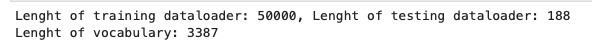

In [3]:
train_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': CAPTIONS_PATH,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': 5,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': 'train',
    'idx2word': None,
    'word2idx': None
}

train_loader, train_dataset = get_loader(**train_loader_params)

val_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': CAPTIONS_PATH,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': 3,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': 'validation',
    'idx2word': train_dataset.vocab.idx2word,
    'word2idx': train_dataset.vocab.word2idx
}

val_loader, val_dataset = get_loader(**val_loader_params)

print(f"Length of training dataloader: {len(train_dataset)}, Length of testing dataloader: {len(val_loader)}")
print(f"Length of vocabulary: {len(train_dataset.vocab.idx2word)}")

Lenght of training dataloader: 50000, Lenght of testing dataloader: 188
Lenght of vocabulary: 3387


In [19]:
len(val_dataset.img_deque), 6000/32, len(train_dataset.img_deque), len(train_dataset.img_deque)/32

(6000, 187.5, 50000, 1562.5)

## Load the model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We are using {device}.")

We are using cuda.


In [11]:
encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

In [12]:
# the loss is a cross entropy loss and ignore the index of <PAD> since it doesn't make any difference
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.word2idx["<PAD>"]).cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.word2idx["<PAD>"])

# combine the parameters of decoder and encoder
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# Adam optimizer
opt_pars = {'lr':1e-3, 'weight_decay':1e-3, 'betas':(0.9, 0.999), 'eps':1e-08}
optimizer = optim.Adam(params, **opt_pars)

In [15]:
model_params = {
    'save_path': CHECKPOINT,
    'batch_size': BATCH_SIZE,
    'embed_size': EMBED_SIZE,
    'hidden_size': HIDDEN_SIZE,
    'num_layers': NUM_LAYERS,
    'vocab_size': len(train_dataset.vocab.idx2word)
}

save_params(**model_params)

## Training

In [16]:
train_params = {
    'encoder': encoder,
    'decoder': decoder,
    'criterion': criterion,
    'optimizer': optimizer,
    'train_loader': train_loader,
    'val_loader': val_loader,
    'total_epoch': TOTAL_EPOCH,
    'device': device,
    'checkpoint_path': CHECKPOINT,
    'print_every': PRINT_EVERY,
    'load_checkpoint': False
}

training_loss, validation_loss = train(**train_params) 

Epoch: [0/1] || Step: [0/1563] || Average Training Loss: 8.1363
Epoch: [0/1] || Step: [500/1563] || Average Training Loss: 3.7902
Epoch: [0/1] || Step: [1000/1563] || Average Training Loss: 3.5424
Epoch: [0/1] || Step: [1500/1563] || Average Training Loss: 3.4285
Epoch: [0/1] || Step: [0/188] || Average Validation Loss: 3.0506
****************************************************************************************************
Epoch: [0/1] || Training Loss = 3.42 || Validation Loss: 3.12 || Time: 10.744735
****************************************************************************************************


## Try with different hyperparamters

In [ ]:
# for data loader
BATCH_SIZE = 128
CAPS_PER_IMAGE = 5 # how many captions for each image to include in data set

# for encoder and decoder
EMBED_SIZE = 1024 # dimension of vocab embedding vector
HIDDEN_SIZE = 512
NUM_LAYERS = 3 #hidden layers in LTSM
vocab_size = len(train_dataset.vocab.idx2word)

# training parameters
TOTAL_EPOCH = 10
CHECKPOINT = '../model/model_v2'
PRINT_EVERY = 500 # run print_every batches and then

In [15]:
model_params = {
    'path': CHECKPOINT,
    'batch_size': BATCH_SIZE,
    'embed_size': EMBED_SIZE,
    'hidden_size': HIDDEN_SIZE,
    'num_layers': NUM_LAYERS,
    'vocab_size': len(train_dataset.vocab.idx2word)
}

save_params(**model_params)

FileNotFoundError: [Errno 2] No such file or directory: '../model/model_v2/model_v2_1_param.json'

In [ ]:
encoder_ = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder_ = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

In [ ]:
# the loss is a cross entropy loss and ignore the index of <PAD> since it doesn't make any difference
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.word2idx["<PAD>"]).cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.word2idx["<PAD>"])

# combine the parameters of decoder and encoder
params = list(decoder_.parameters()) + list(encoder_.embed.parameters())

# Adam optimizer
opt_pars = {'lr':3e-4, 'weight_decay':1e-3, 'betas':(0.9, 0.999), 'eps':1e-08}
optimizer = optim.Adam(params, **opt_pars)

In [ ]:
train_params = {
    'encoder': encoder_,
    'decoder': decoder_,
    'criterion': criterion,
    'optimizer': optimizer,
    'train_loader': train_loader,
    'val_loader': val_loader,
    'total_epoch': TOTAL_EPOCH,
    'device': device,
    'checkpoint_path': CHECKPOINT,
    'print_every': PRINT_EVERY,
    'load_checkpoint': False
}

training_loss, validation_loss = train(**train_params) 